In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 3) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

In [3]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from transformers import SamModel, SamProcessor
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

yolo_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
yolo_model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

/Users/santhoshvadivel/miniconda3/envs/aiml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


[{'scores': tensor([0.9992], grad_fn=<IndexBackward0>), 'labels': tensor([16]), 'boxes': tensor([[410.7068, 268.0577, 615.0736, 580.3915]], grad_fn=<IndexBackward0>)}]
Detected 16 | bird with confidence 0.999 at location [410.71, 268.06, 615.07, 580.39]


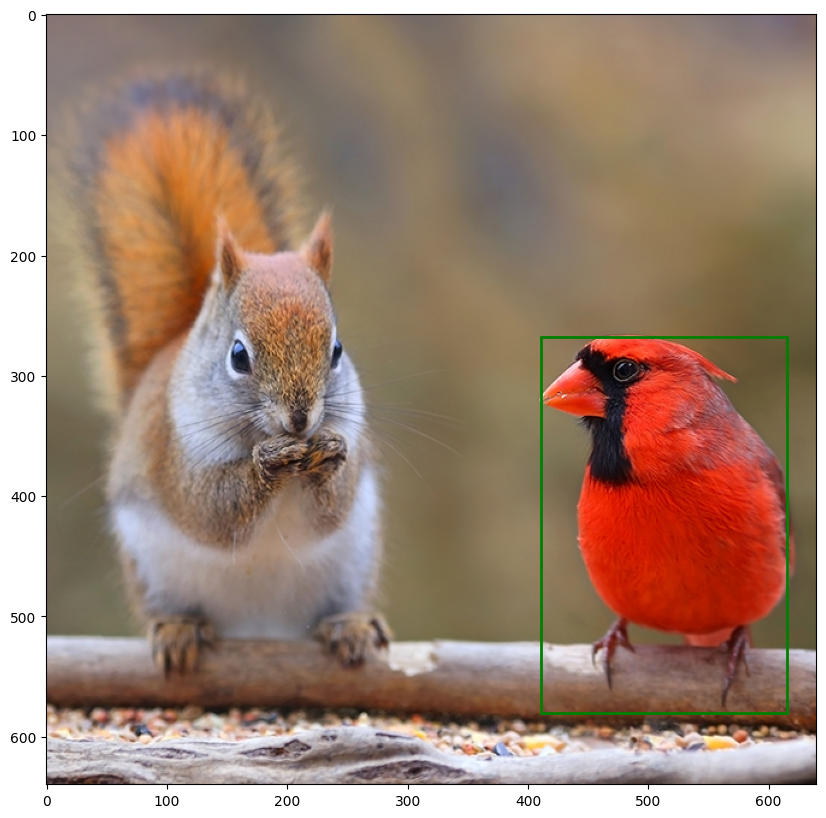

In [6]:
from PIL import Image

raw_image = Image.open('./images/bns/bns-1.jpeg').convert("RGB")

inputs = yolo_processor(images=raw_image, return_tensors="pt")
outputs = yolo_model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([raw_image.size[::-1]])
raw_result = yolo_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)
results = raw_result[0]
print(raw_result)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {label.item()} | {yolo_model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    show_boxes_on_image(raw_image, [box])

In [7]:
input_boxes = [np.ndarray.tolist(results["boxes"].detach().numpy())]
inputs = sam_processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

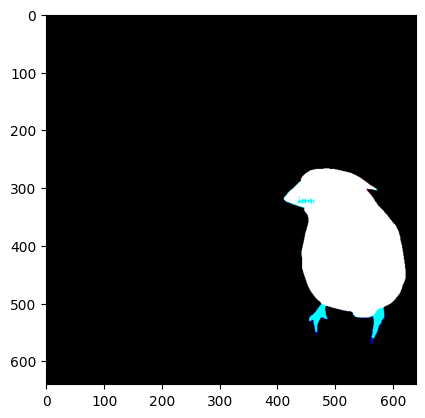

In [8]:
mask_plot = []
for index, mask in enumerate(masks[0]):
    mask_plot = (mask_plot == True) | (mask[:, :, :] == True)

mask_plot = mask_plot.float()
plt.imshow(mask_plot.permute(1, 2, 0))

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline

pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)

In [10]:
pipeline = pipeline.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

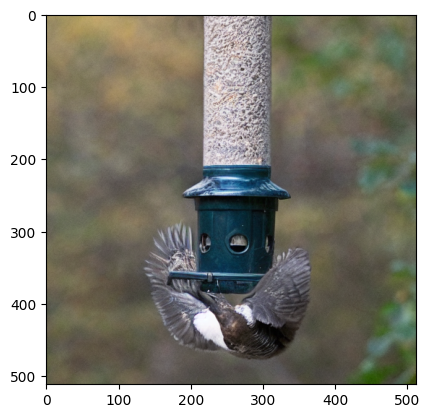

In [167]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import torchvision.transforms as T

tensor = mask_plot
transform = T.ToPILImage()
mask_image = transform(tensor).resize((512, 512))
init_image = raw_image.resize((512, 512))

prompt = 'bird flying near a birfeeder'
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
plt.imshow(image)

In [24]:
# import os
# arr = os.listdir()
# f = filter(lambda x: '-birdsRemoved.jpeg' in x, arr)
# # f"{list(f)[0].split('.')[0]}-andSquirrelsReplaced.jpeg"
# "raw_image_of-bns-2-birdsRemoved.jpeg".split('raw_image_of-')

from PIL import Image
import numpy as np

raw_image = Image.open('./images/bns/bns-1.jpeg').convert("RGB")
# plt.imread('./images/bns/bns-1.jpeg')
plt.imsave('./new.jpeg', np.array(raw_image))
